In [1]:
from environment import GridWorld
from agent import QLearner, RandomAgent

In [2]:
import random
random.seed()
print(random.getstate())

(3, (2147483648, 4157534603, 1905753842, 2450984932, 2403677026, 1337029783, 4061701958, 3278187659, 2322770640, 2589483228, 1143696315, 4277632153, 8450585, 894597729, 1712470486, 933698607, 3531808942, 3089069489, 1423746446, 2393176375, 3684568539, 1143399612, 4036891828, 3577411233, 212236001, 3360738213, 180249049, 3539267469, 1079772778, 3397401167, 1001776346, 3685921007, 2916434552, 78463374, 134054751, 3007238134, 1522584905, 2526076561, 942002945, 2594909641, 3786243990, 499873229, 139899657, 815758161, 1079745915, 4189614197, 1269932177, 1927474190, 2496827679, 2126353721, 3717569827, 328172622, 614164433, 4178248123, 420499906, 971831013, 1153849728, 1191005697, 3981491683, 1242138724, 2972838300, 3025903706, 2220478736, 572056008, 365184950, 1106205276, 2304366225, 3062591286, 3612691509, 146700209, 3931363199, 129022619, 326003039, 1261184057, 3912250304, 1057508838, 2645999599, 1510757480, 646690216, 2609061042, 1020008653, 457520629, 2054553815, 3824826049, 3109650599, 

In [3]:
experiments = (
{
    "discount_rate": lambda _: 0.9,
    "learning_rate": lambda _: 0.1,
    "exploration_rate": lambda _: 0.25
},{
    "discount_rate": lambda _: 0.9,
    "learning_rate": lambda t: 1/t,
    "exploration_rate": lambda t: 1/t
},
    {
    "discount_rate": lambda _: 0.9,
    "learning_rate": lambda _: 0.1,
    "exploration_rate": lambda t: 1/t
},
{
    "discount_rate": lambda _: 0.9,
    "learning_rate": lambda t: 1/t,
    "exploration_rate": lambda _: 0.1
})

In [4]:
def simulate_climbing_game(agent1, agent2, environment, t):
    state = environment.get_state()
    while not environment.isTerminalState(state):
        t += 1
        action1 = agent1.action_selection(state, None, t)
        action2 = agent2.action_selection(state, None, t)
        reward, new_state = environment.respond_to_action((action1, action2))
        agent1.update(state, action1, new_state, reward, t)
        agent2.update(state, action2, new_state, reward, t)
        state = new_state

    return t


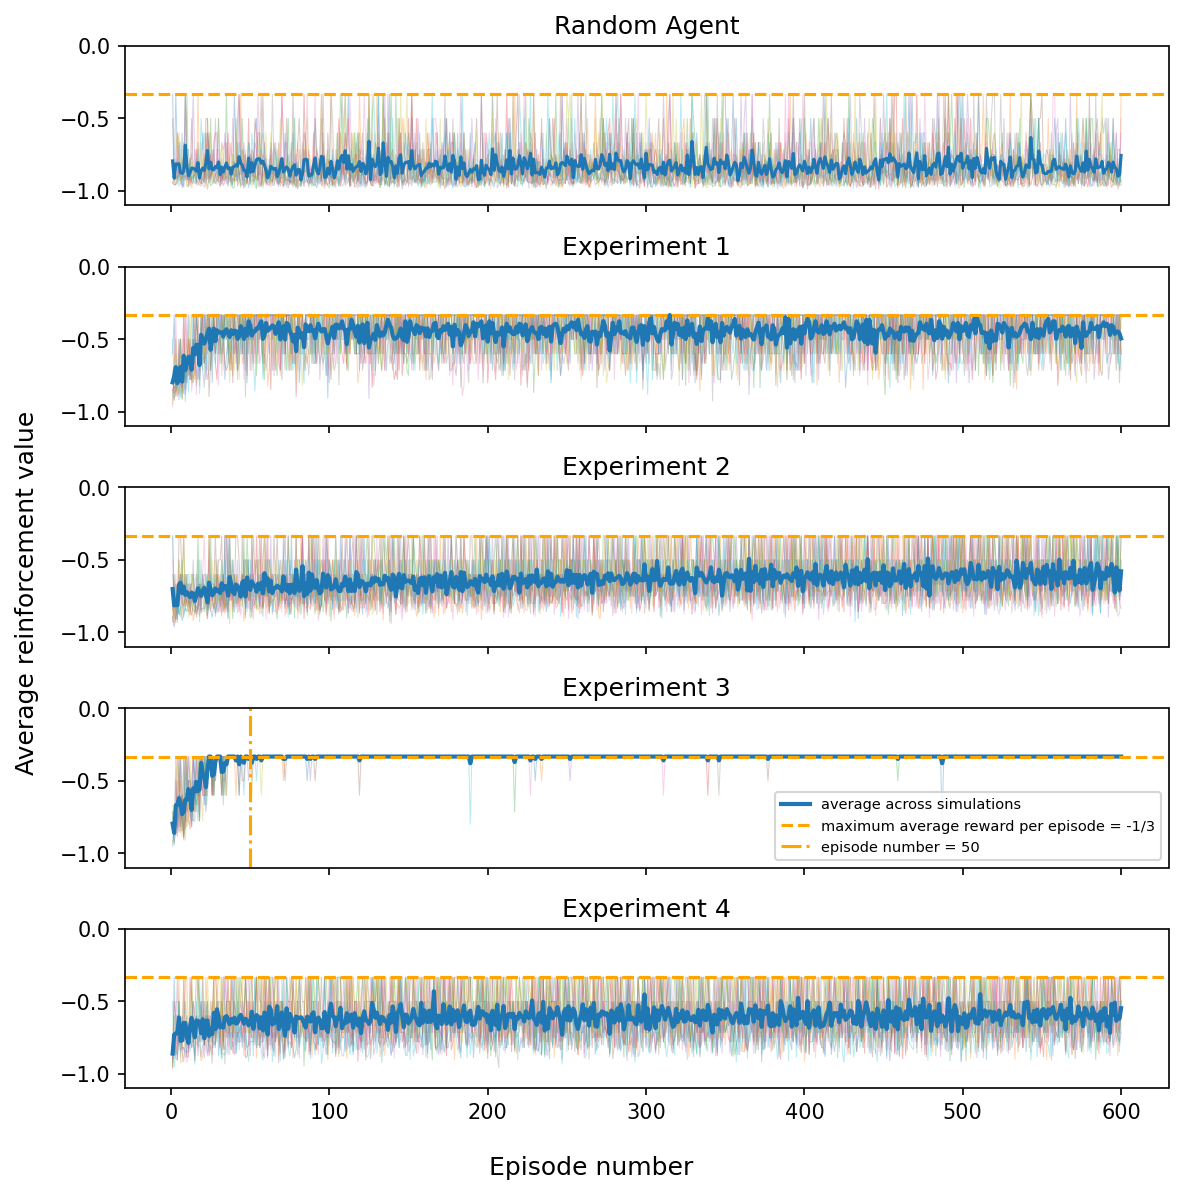

In [5]:
def simulate_grid_world(agent, task, t):
    state = task.get_state()
    while not task.isTerminalState(state):
        t += 1
        action = agent.action_selection(state, None, t)
        reward, new_state = task.respond_to_action(action)
        agent.update(state, action, new_state, reward, t)
        state = new_state
    return t

import numpy as np

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(8, 8), sharex=True)
fig.set_dpi(150)

num_episodes = 600 # 150 was good
num_simulations = 10

for j, exp in enumerate(experiments):
    i = j + 1
    rewards = np.zeros((num_simulations, num_episodes))

    discount_rate = exp["discount_rate"]
    learning_rate = exp["learning_rate"]
    exploration_rate = exp["exploration_rate"]

    for sim in range(num_simulations):
        t = 0
        task = GridWorld(4, start_state = (3,0), terminal_states=[(0,0), (3,3)])
        agent = QLearner(task, exploration_rate, learning_rate, discount_rate)
        prev_t = t
        for ep in range(num_episodes):
            t = simulate_grid_world(agent, task, t)
            num_steps = t - prev_t
            rewards[sim][ep] = agent.accumulated_reward / num_steps
            agent.accumulated_reward = 0
            task.reset_state()
            prev_t = t
        axs[i].plot(range(1, num_episodes + 1), rewards[sim], alpha=0.3, lw=0.5) # if sim < 1 else do_nothing()
    
    average = np.average(rewards, axis = 0)
    axs[i].plot(range(1, num_episodes + 1), average, lw=2, label="average across simulations")

    
    median = np.median(rewards, axis = 0)
    #axs[i].plot(range(1, num_episodes + 1), median, label="median", lw=2)
    
    axs[i].set_title("Experiment {}".format(i))

    # max reward
    #axs[i].axhline(-1, label="Maximum reward = -1", ls = '--')

        
rewards = np.zeros((num_simulations, num_episodes))
# random agent
for sim in range(num_simulations):
    t = 0
    task = GridWorld(4, start_state = (3,0), terminal_states=[(0,0), (3,3)])
    agent = RandomAgent(task)
    state = task.get_state()
    prev_t = t
    for ep in range(num_episodes):
        t = simulate_grid_world(agent, task, t)
        num_steps = t - prev_t
        rewards[sim][ep] = agent.accumulated_reward / num_steps
        agent.accumulated_reward = 0
        task.reset_state()
        prev_t = t
    axs[0].plot(range(1, num_episodes + 1), rewards[sim], alpha=0.3, lw=0.5)

average = np.average(rewards, axis = 0)
axs[0].plot(range(1, num_episodes + 1), average)

median = np.median(rewards, axis = 0)
#axs[0].plot(range(1, num_episodes + 1), median, label="median", lw=2)

axs[0].set_title("Random Agent")


# max reward
for i, ax in enumerate(axs):
    ax.axhline(-1/3, label="maximum average reward per episode = -1/3", ls = '--', c='orange')

    if(i == 3):
        ep_number = 50
        axs[i].axvline(ep_number, ls='-.', c='orange', label="episode number = {}".format(ep_number))

        axs[i].legend(loc='best', fontsize=7)
    
    ax.set_ylim(-1.1, 0)

        
fig.supxlabel('Episode number')
fig.supylabel('Average reinforcement value')

plt.tight_layout()